In [ ]:
!pip install fal-client

In [ ]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# https://fal.ai/dashboard/keys
# put your key in the .env file with the name FAL_KEY


Original Image with padding:


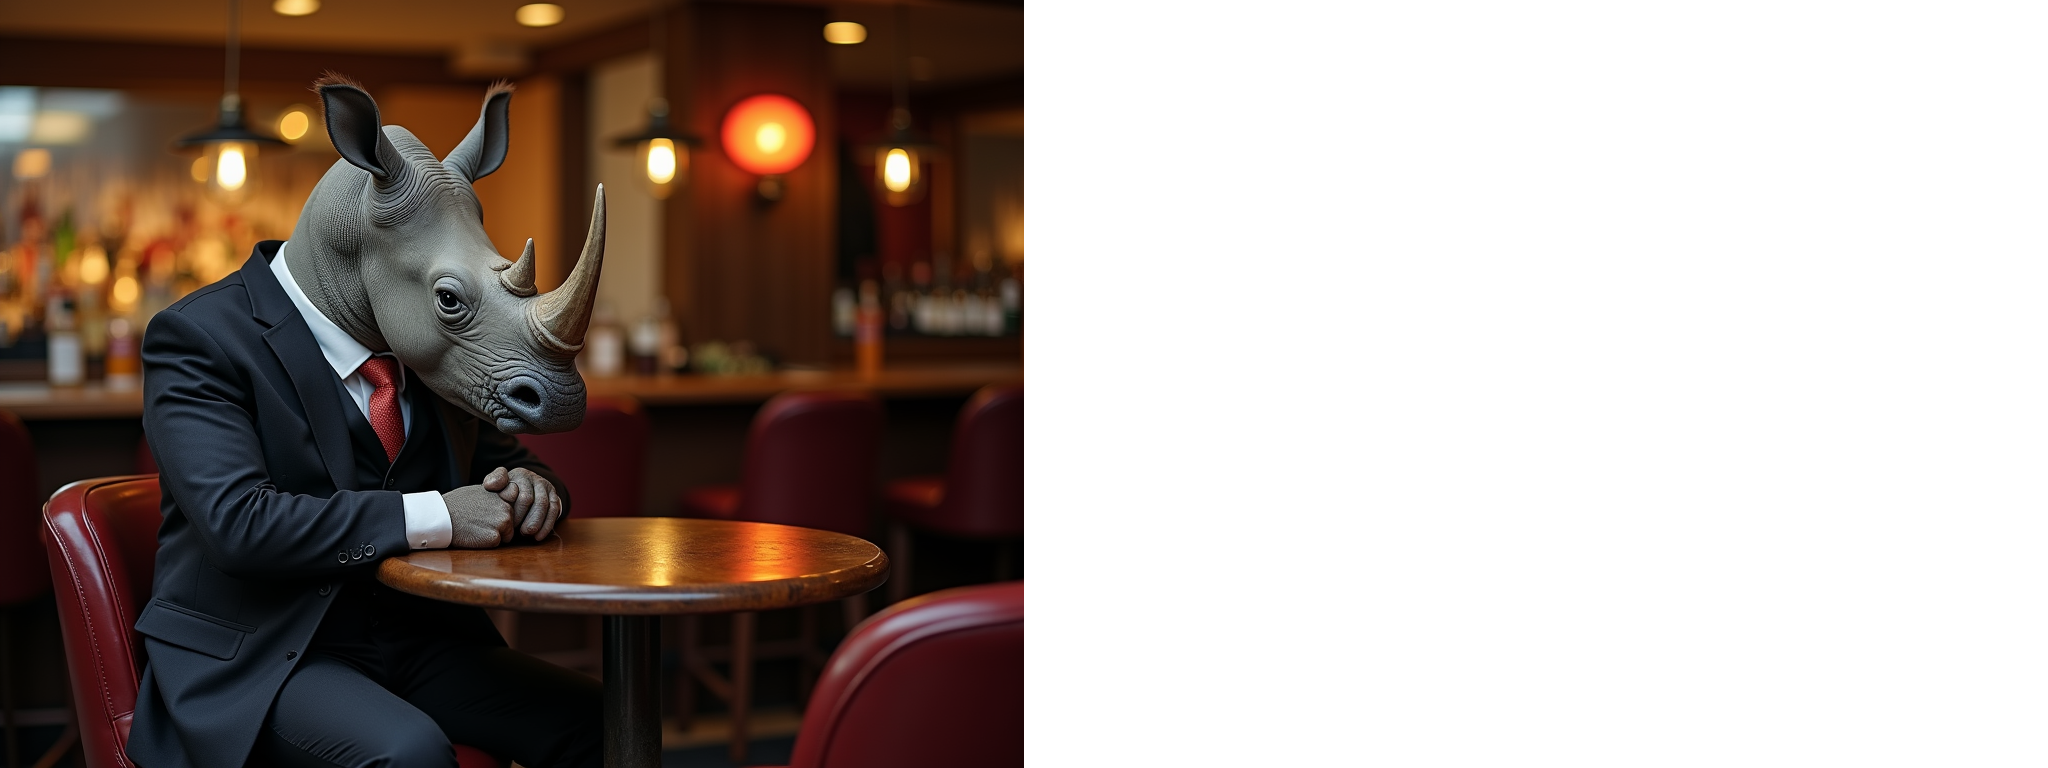


Added Mask:


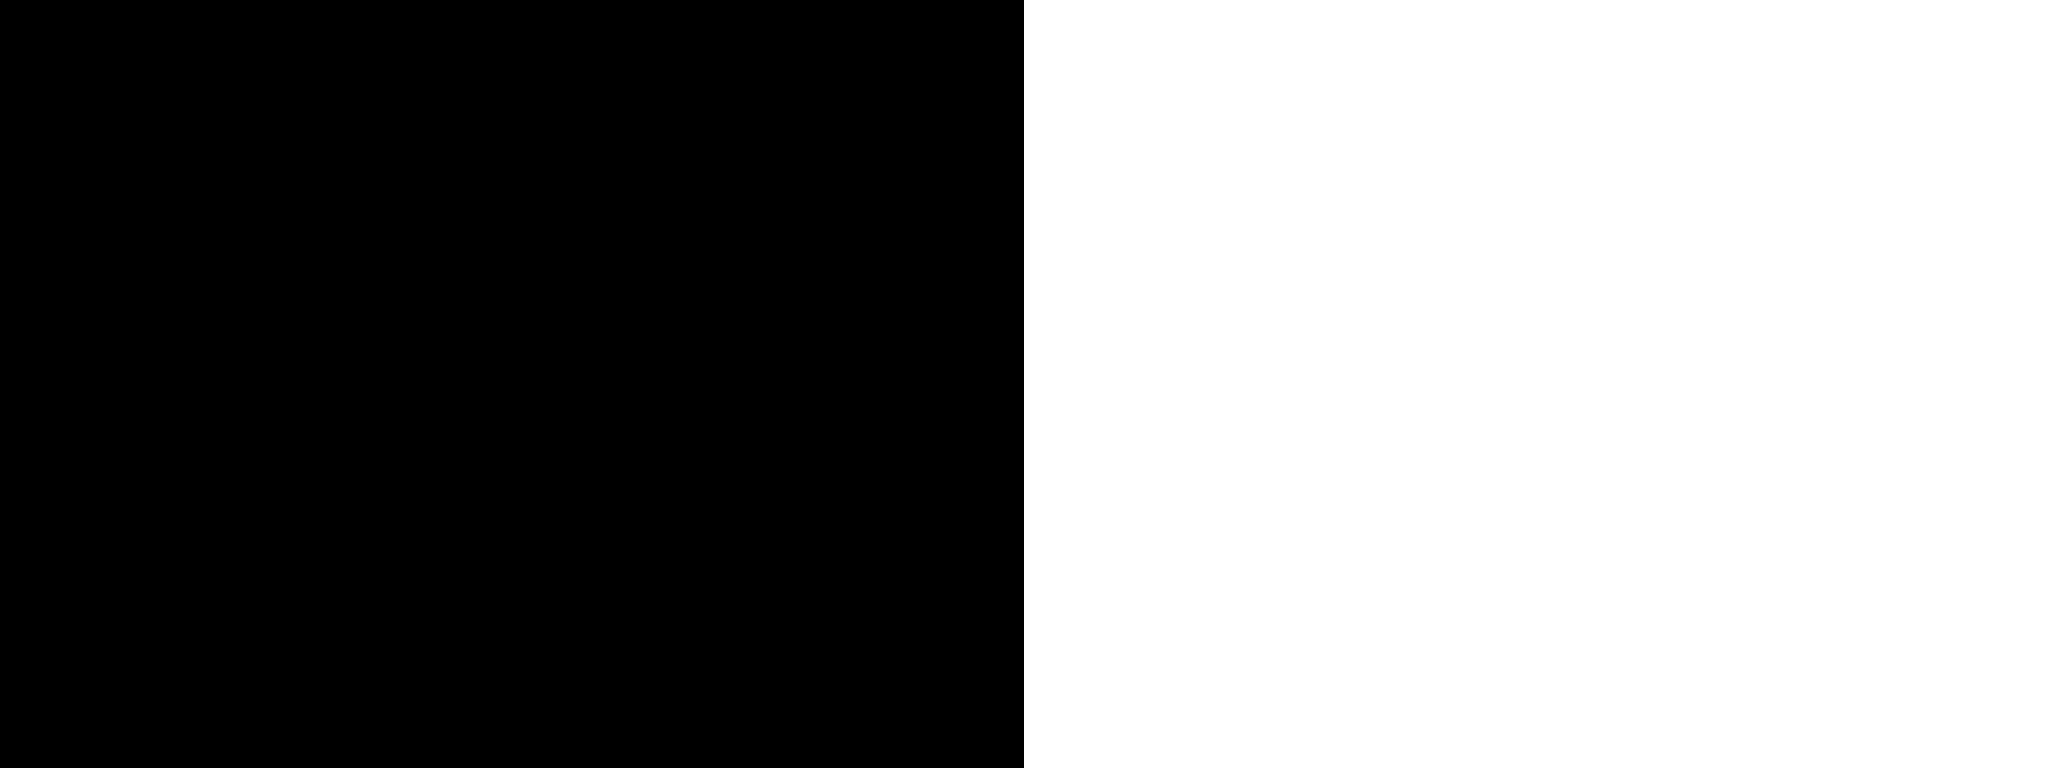

In [5]:
import fal_client
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

original_img = Image.open("rhino-suit.png")

# Create new image with double width and white background
new_width = original_img.size[0] * 2  # Double the width
new_height = original_img.size[1]     # Keep original height
new_img = Image.new('RGB', (new_width, new_height), 'white')

# Paste original image on the left side
new_img.paste(original_img, (0, 0))  # Paste at left edge

# Save and upload the new image
new_img.save("rhino-suit-padded.png")
image_url = fal_client.upload_file("rhino-suit-padded.png")

# Create mask: Black (0) for the area to preserve (original image on the left),
# White (255) for the area to fill (newly added right side).
mask_img = Image.new('L', (new_width, new_height), 255)  # Initialize with all white (area to be filled by default)
# Define the region of the original image that should be preserved
original_image_region_on_canvas = (0, 0, original_img.size[0], original_img.size[1])
# Paste black onto the region of the original image to mark it for preservation
mask_img.paste(0, original_image_region_on_canvas)

# Save mask image temporarily to upload it
mask_img.save("temp_mask.png")
mask_url = fal_client.upload_file("temp_mask.png")

# Display images
print("\nOriginal Image with padding:")
display(new_img)
print("\nAdded Mask:")
display(mask_img)


{'images': [{'url': 'https://fal.media/files/tiger/whsGEQfbp-j-fgcSRY2k0_3bdffc1205be46d7810a7c4dcff52f75.jpg', 'width': 1440, 'height': 512, 'content_type': 'image/jpeg'}], 'timings': {}, 'seed': 1663735062, 'has_nsfw_concepts': [False], 'prompt': '(right) photo of the same rhino wearing tennis clothes carrying a tennis racket playing tennis on a tennis court'}

After transformation:


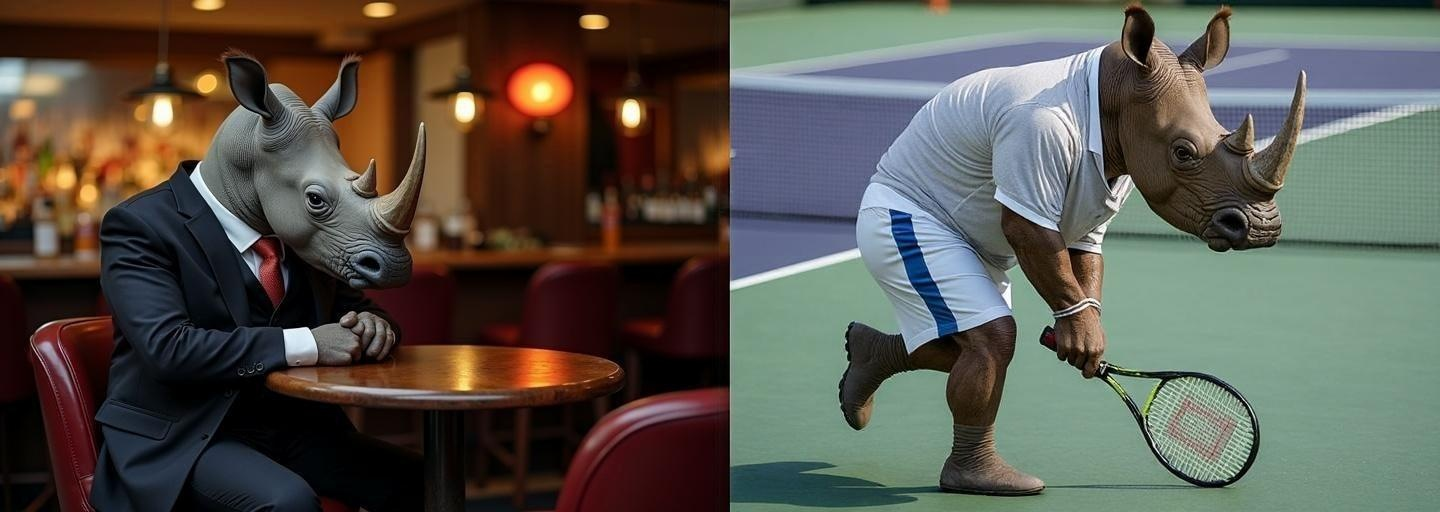

In [8]:
def on_queue_update(update):
    if isinstance(update, fal_client.InProgress):
        for log in update.logs:
           print(log["message"])

prompt = "(right) photo of the same rhino wearing tennis clothes carrying a tennis racket playing tennis on a tennis court"

result = fal_client.subscribe(
    "fal-ai/flux-pro/v1/fill", 
    arguments={
        "image_url": image_url,
        "mask_url": mask_url,
        "prompt": prompt,
        "image_size": {
            "width": new_width,
            "height": new_height
        }
    },
    with_logs=True,
    on_queue_update=on_queue_update,
)
print(result)

print("\nAfter transformation:")

# Get and display transformed image
image_url = result['images'][0]['url']
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
display(img)